# tascCODA - Tree-aggregated compositional analysis

This notebook is a tutorial on how to use tascCODA [Ostner et al., 2021](https://www.frontiersin.org/articles/10.3389/fgene.2021.766405/full) for tree-aggregated compositional analysis of high-throughput sequencing (HTS) data.

For this example, we use single-cell RNA sequencing data {cite}`Ostner2021`.
However, there are no limitations to use tascCODA with other HTS data, such as 16S rRNA sequencing.

The particular dataset for this analysis was generated by [Smillie et al., 2019](https://doi.org/10.1016/j.cell.2019.06.029).
It contains samples from two different regions in the small intestine of mice - Epithelium and Lamina Propria - and three different inflammation conditions - healthy, non-inflamed and inflamed. In total, we have 365.492 cells from 51 cell types in 133 samples.

In [1]:
import matplotlib.pyplot as plt
import pertpy as pt

## Dataset

First, we read in the per-cell data. In this dataset, samples are specified as "Subject", and cell types are denoted as "Cluster". Interesting covariates are the samples' location and health status.
The columns "Major_l1" - "Major_l4" and "Cluster" describe a lineage tree over the cell types.

In [2]:
smillie_counts = pt.dt.smillie_2019()
smillie_counts.obs

,Origin,Subject,Sample,Location,Replicate,Health,Cluster,nGene,nUMI,Major_l1,Major_l2,Major_l3,Major_l4
N7.EpiA.AAGGCTACCCTTTA,Imm,N7,EpiA,Epi,A,Non-inflamed,Plasma,624.0,7433.0,Immune,Lymphoid,B cells,Plasma4
N7.EpiA.AAGGTGCTACGGAG,Imm,N7,EpiA,Epi,A,Non-inflamed,CD8+ IELs,558.0,1904.0,Immune,Lymphoid,T cells,CD8+ T
N7.EpiA.AAGTAACTTGCTTT,Imm,N7,EpiA,Epi,A,Non-inflamed,CD8+ IELs,437.0,1366.0,Immune,Lymphoid,T cells,CD8+ T
N7.EpiA.ACAATAACCCTCAC,Imm,N7,EpiA,Epi,A,Non-inflamed,Plasma,484.0,5161.0,Immune,Lymphoid,B cells,Plasma4
N7.EpiA.ACAGTTCTTCTACT,Imm,N7,EpiA,Epi,A,Non-inflamed,CD8+ IELs,470.0,1408.0,Immune,Lymphoid,T cells,CD8+ T
...,...,...,...,...,...,...,...,...,...,...,...,...,...
N110.LPB.TTTGGTTGTGTGGCTC,Epi,N110,LPB,LP,B,Inflamed,Immature Enterocytes 2,2553.0,11705.0,Epithelial,Epithelial,Absorptive,Immature cells
N110.LPB.TTTGGTTTCCTTAATC,Epi,N110,LPB,LP,B,Inflamed,TA 2,3234.0,16164.0,Epithelial,Epithelial,Absorptive,TA cells
N110.LPB.TTTGGTTTCTTACCTA,Epi,N110,LPB,LP,B,Inflamed,Enterocyte Progenitors,258.0,384.0,Epithelial,Epithelial,Absorptive,Immature cells
N110.LPB.TTTGTCAAGGATGGAA,Epi,N110,LPB,LP,B,Inflamed,TA 1,487.0,772.0,Epithelial,Epithelial,Absorptive,TA cells


In [3]:
smillie_counts

AnnData object with n_obs × n_vars = 365492 × 18172
    obs: 'Origin', 'Subject', 'Sample', 'Location', 'Replicate', 'Health', 'Cluster', 'nGene', 'nUMI', 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4'

Next, we convert the data to a (samples x cell types) object.
To identify the statistical samples, we need to combine the "Subject" and "Sample" columns.
We also need to extract the tree-structured cell lineage information (Lineages `Major_l1` - `Major_l4`) from the data, generate a Newick string through `tasccoda.tree_utils.df2newick()` and convert it into a [ete3](http://etetoolkit.org/) tree object. This is all done within the `load` function by specifying.

In [4]:
tasccoda_model = pt.tl.Tasccoda()
smillie_data = tasccoda_model.load(
    smillie_counts,
    type="cell_level",
    cell_type_identifier="Cluster",
    sample_identifier=["Subject", "Sample"],
    covariate_obs=["Location", "Health"],
    levels_orig=["Major_l1", "Major_l2", "Major_l3", "Major_l4", "Cluster"],
    add_level_name=True,
)
smillie_data

MuData object with n_obs × n_vars = 365625 × 18223
  2 modalities
    rna:	365492 x 18172
      obs:	'Origin', 'Subject', 'Sample', 'Location', 'Replicate', 'Health', 'Cluster', 'nGene', 'nUMI', 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4', 'scCODA_sample_id'
    coda:	133 x 51
      obs:	'Sample', 'Location', 'Health', 'Subject'
      var:	'n_cells'
      uns:	'tree'

We can also visualize the tree:

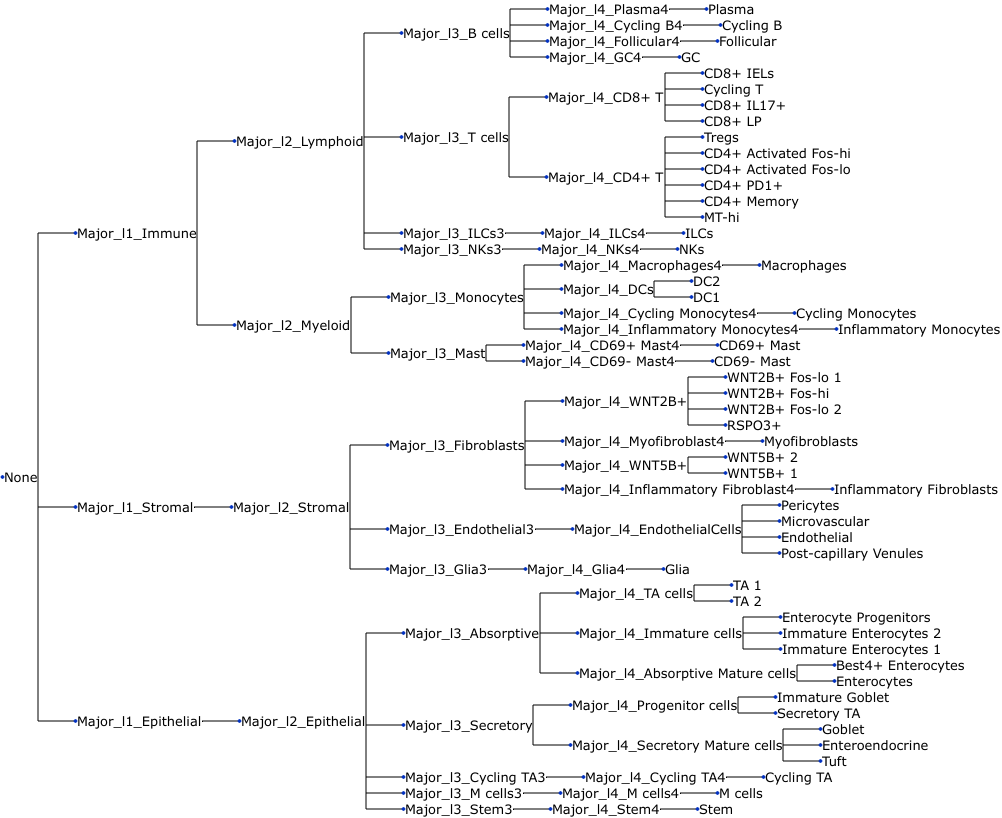

In [5]:
tasccoda_model.plot_draw_tree(smillie_data["coda"])

For this tutorial, we focus on finding changes between healthy and non-inflamed tissue in the Lamina Propria. Therefore, we subset the data accordingly, and end up with 48 samples:

In [6]:
smillie_data.mod["coda_LP"] = smillie_data["coda"][
    (smillie_data["coda"].obs["Health"].isin(["Healthy", "Non-inflamed"]))
    & (smillie_data["coda"].obs["Location"] == "LP")
]
smillie_data

MuData object with n_obs × n_vars = 365625 × 18223
  3 modalities
    rna:	365492 x 18172
      obs:	'Origin', 'Subject', 'Sample', 'Location', 'Replicate', 'Health', 'Cluster', 'nGene', 'nUMI', 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4', 'scCODA_sample_id'
    coda:	133 x 51
      obs:	'Sample', 'Location', 'Health', 'Subject'
      var:	'n_cells'
      uns:	'tree'
    coda_LP:	48 x 51
      obs:	'Sample', 'Location', 'Health', 'Subject'
      var:	'n_cells'
      uns:	'tree'

A quick plot of the data with the `sccoda.util.data_visualization` module shows us that there are some changes in relative abundance in the data:

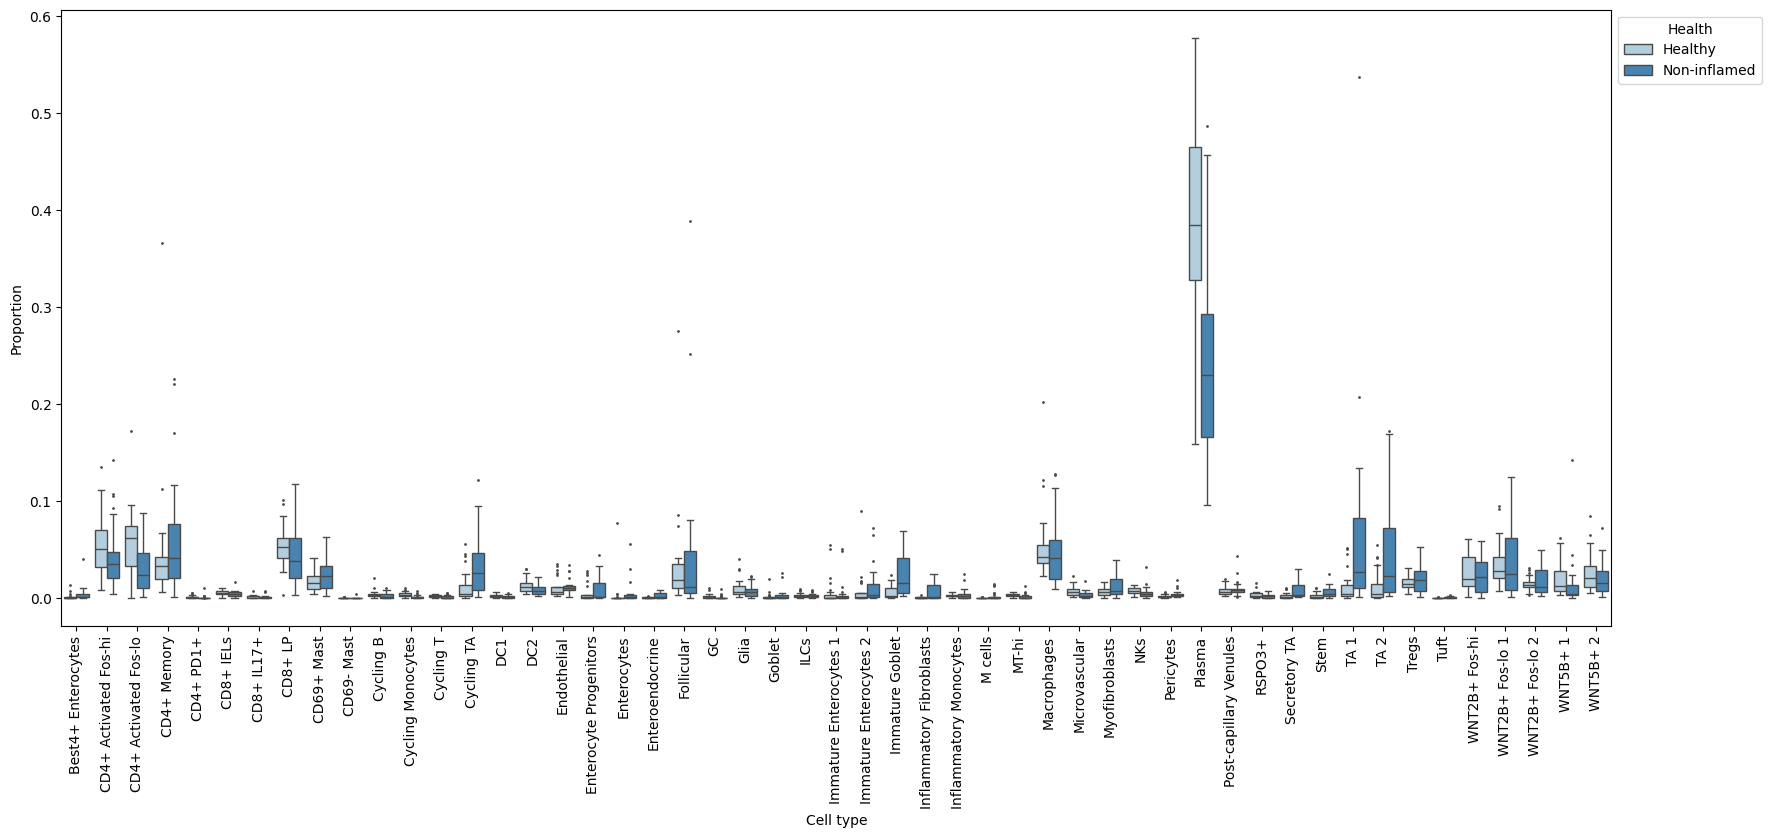

In [7]:
tasccoda_model.plot_boxplots(smillie_data, modality_key="coda_LP", feature_name="Health", figsize=(20, 8))
plt.show()

## Run tascCODA

Inferring credible effects with tascCODA on our data is now simply a matter of running the sampling process. The model creation and inference works analogous to scCODA (see the scCODA quickstart tutorial)

As hyperparameters, we have to specify in the `prepare` function:
- The reference cell type (which is assumed to be unchanged between the conditions): We use the `automatic` setting here, which chooses a reference that induces minimal compositional effects (here we use the automatic suggestion - NK cells)
- The model formula (R-style formula string, just as in scCODA)
- The aggregation bias $\phi$, defined in the [tascCODA paper](https://www.frontiersin.org/articles/10.3389/fgene.2021.766405/full). We go with an unbiased aggregation (`pen_args={"phi": 0}`) here.
- The key in `.uns` of our MuData modality where the tree is saved.

Then, we run No-U-turn sampling via `run_nuts` with the default settings of 11.000 samples, of which 1.000 are discarded as burn-in

In [8]:
smillie_data = tasccoda_model.prepare(
    smillie_data,
    modality_key="coda_LP",
    tree_key="tree",
    reference_cell_type="automatic",
    formula="Health",
    pen_args={"phi": 0},
)
smillie_data

• Automatic reference selection! Reference cell type set to NKs
• Zero counts encountered in data! Added a pseudocount of 0.5.


/home/lukas/miniforge3/envs/pertpy/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/lukas/code/pertpy/pertpy/tools/_coda/_base_coda.py:123: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  sample_adata.X = sample_adata.X.astype(dtype)
/home/lukas/code/pertpy/pertpy/tools/_coda/_base_coda.py:130: ImplicitModificationWarning: Setting element `.obsm['covariate_matrix']` of view, initializing view as actual.
  sample_adata.obsm["covariate_matrix"] = np.array(covariate_matrix[:, 1:]).astype(dtype)


MuData object with n_obs × n_vars = 365625 × 18223
  3 modalities
    rna:	365492 x 18172
      obs:	'Origin', 'Subject', 'Sample', 'Location', 'Replicate', 'Health', 'Cluster', 'nGene', 'nUMI', 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4', 'scCODA_sample_id'
    coda:	133 x 51
      obs:	'Sample', 'Location', 'Health', 'Subject'
      var:	'n_cells'
      uns:	'tree'
    coda_LP:	48 x 51
      obs:	'Sample', 'Location', 'Health', 'Subject'
      var:	'n_cells'
      uns:	'tree', 'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'

In [9]:
tasccoda_model.run_nuts(smillie_data, modality_key="coda_LP")

sample: 100%|██████████| 11000/11000 [02:48<00:00, 65.43it/s, 63 steps of size 7.85e-02. acc. prob=0.91]


## Result analysis

Calling `summary`, we can see the most relevant information for further analysis:



In [10]:
tasccoda_model.summary(smillie_data, modality_key="coda_LP")

                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 48 samples, 51 cell types                                    │
│ Reference cell type                        │ NKs                                                                │
│ Formula                                    │ Health                                                             │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           Final Parameter  Expected Sample                                                      │
│ Cluster                                                                                                         │
│ Best4+ Enterocytes            -1.182            10.358                                                          │
│ CD4+ Activated Fos-hi          1.560           160.732                                                          │
│ CD4+ Activated Fos-lo          1.609           168.804                                                          │
│ CD4+ Memory                    1.319           126.310                                                          │
│ CD4+ PD1+                     -0.932            13.300                                                          │
│ CD8+ IELs                     -0.112            30.197                                                          │
│ CD8+ IL17+                    -0.803            15.131                                                          │
│ CD8+ LP                        1.602           167.626                                                          │
│ CD69+ Mast                     0.590            60.931                                                          │
│ CD69- Mast                    -1.357             8.695                                                          │
│ Cycling B                     -0.478            20.942                                                          │
│ Cycling Monocytes             -0.565            19.197                                                          │
│ Cycling T                     -0.702            16.739                                                          │
│ Cycling TA                     0.089            36.919                                                          │
│ DC1                           -0.603            18.481                                                          │
│ DC2                            0.353            48.074                                                          │
│ Endothelial                    0.120            38.082                                                          │
│ Enterocyte Progenitors        -0.906            13.650                                                          │
│ Enterocytes                   -1.223             9.942                                                          │
│ Enteroendocrine               -1.264             9.542                                                          │
│ Follicular                     0.830            77.458                                                          │
│ GC                            -0.912            13.568                                                          │
│ Glia                          -0.104            30.439                                                          │
│ Goblet                        -1.218             9.992                                                          │
│ ILCs                          -0.846            14.494                                                          │
│ Immature Enterocytes 1        -1.065            11.643                                                          │
│ Immature Enterocytes 2        -0.826            14.787                                                          │
│ Immature Goblet               -0.329            24.306                                                          │
│ Inflammatory Fibroblasts      -0.970            12.804                                                          │
│ Inflammatory Monocytes        -0.538            19.722

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                Effect  Expected Sample  log2-fold change                        │
│ Covariate            Cell Type                                                                                  │
│ HealthT.Non-inflamed Best4+ Enterocytes         0.000      19.415             0.906                             │
│                      CD4+ Activated Fos-hi     -0.676     153.247            -0.069                             │
│                      CD4+ Activated Fos-lo     -1.031     112.849            -0.581                             │
│                      CD4+ Memory               -0.676     120.428            -0.069                             │
│                      CD4+ PD1+                 -0.676      12.680            -0.069                             │
│                      CD8+ IELs                 -0.676      28.791            -0.069                             │
│                      CD8+ IL17+                -0.676      14.426            -0.069                             │
│                      CD8+ LP                   -0.676     159.820            -0.069                             │
│                      CD69+ Mast                -0.252      88.770             0.543                             │
│                      CD69- Mast                -0.252      12.668             0.543                             │
│                      Cycling B                 -0.707      19.357            -0.114                             │
│                      Cycling Monocytes         -0.607      19.610             0.031                             │
│                      Cycling T                 -0.676      15.959            -0.069                             │
│                      Cycling TA                 0.000      69.203             0.906                             │
│                      DC1                       -0.607      18.879             0.031                             │
│                      DC2                       -0.607      49.109             0.031                             │
│                      Endothelial               -0.365      49.553             0.380                             │
│                      Enterocyte Progenitors     0.000      25.586             0.906                             │
│                      Enterocytes                0.000      18.635             0.906                             │
│                      Enteroendocrine            0.000      17.887             0.906                             │
│                      Follicular                -0.707      71.597            -0.114                             │
│                      GC                        -0.707      12.542            -0.114                             │
│                      Glia                      -0.365      39.609             0.380                             │
│                      Goblet                     0.000      18.729             0.906                             │
│                      ILCs                       0.000      27.168             0.906                             │
│                      Immature Enterocytes 1     0.000      21.825             0.906                             │
│                      Immature Enterocytes 2     0.000      27.717             0.906                             │
│                      Immature Goblet            0.000      45.561             0.906                             │
│                      Inflammatory Fibroblasts  -0.365      16.661             0.380                             │
│                      Inflammatory Monocytes    -0.607 

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Nodes                                                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Covariate=Health[T.Non-inflamed]_node                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                   Final Parameter  Is credible                                                  │
│ Node                                                                                                            │
│ Major_l1_Immune                        0.00           False                                                     │
│ Major_l2_Stromal                      -0.36            True                                                     │
│ Major_l2_Epithelial                    0.00           False                                                     │
│ Major_l2_Lymphoid                      0.00           False                                                     │
│ Major_l2_Myeloid                      -0.25            True                                                     │
│ Major_l3_Fibroblasts                   0.00           False                                                     │
│ Major_l4_EndothelialCells              0.00           False                                                     │
│ Glia                                   0.00           False                                                     │
│ Major_l3_Absorptive                    0.00           False                                                     │
│ Major_l3_Secretory                     0.00           False                                                     │
│ Cycling TA                             0.00           False                                                     │
│ M cells                                0.00           False                                                     │
│ Stem                                   0.00           False                                                     │
│ Major_l3_B cells                      -0.71            True                                                     │
│ Major_l3_T cells                      -0.68            True                                                     │
│ ILCs                                   0.00           False                                                     │
│ NKs                                    0.00           False                                                     │
│ Major_l3_Monocytes                    -0.35            True                                                     │
│ Major_l3_Mast                          0.00           False                                                     │
│ Major_l4_WNT2B+                        0.00           False                                                     │
│ Major_l4_WNT5B+                        0.00           False                                                     │
│ Myofibroblasts                         0.00           False                                                     │
│ Inflammatory Fibroblasts               0.00           False                                                     │
│ Pericytes                              0.00           False                                                     │
│ Microvascular                          0.00           False                                                     │
│ Endothelial                            0.00           False                                                     │
│ Post-capillary Venules                 0.00           False                                                     │
│ Major_l4_TA cells                      0.34           

**Model properties**

First, the summary shows an overview over the model properties:
* Number of samples/cell types
* The reference cell type.
* The formula used

The model has three types of parameters that are relevant for analysis - intercepts, feature-level effects and node-wise effects.
These can be interpreted like in a standard regression model:
Intercepts show how the cell types are distributed without any active covariates, effects show how the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The "Expected sample" column gives some context to the numerical values.
If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset,
then this distribution over the cell types would be most likely.

**Feature-level Effects**

For the feature-level effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types, as sums over node-level effects on all parent nodes.
Most important is the distinction between zero and non-zero entries
A value of zero means that no statistically credible effect was detected.
For a value other than zero, a credible change was detected. A positive sign indicates an increase, a negative sign a decrease in abundance.

Since the numerical values of the "Effect" column are not straightforward to interpret, the "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of the change.
The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts.
The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section.
Since the data is compositional, cell types for which no credible change was detected, will still change in abundance as well, as soon as a credible effect is detected on another cell type due to the sum-to-one constraint.
If there are no credible effects for a covariate, its expected sample will be identical to the intercept sample, therefore the log2-fold change is 0.

**Node-level effects**

These parameters are the most important ones. They describe, at which points in the tree a credible change in abundance was detected. The data frame just has two columns:
The "Final Parameter" column shows the effect values, the "Is credible" column simply depicts whether the inferred effect is different from 0, i.e. credible.
In a normal tascCODA analysis, we are interested in which subtrees (i.e. nodes) have a nonzero effect, which we can easily extract:

In [11]:
tasccoda_model.credible_effects(smillie_data, modality_key="coda_LP")

Covariate                    Node               
Health[T.Non-inflamed]_node  Major_l1_Immune        False
                             Major_l2_Stromal        True
                             Major_l2_Epithelial    False
                             Major_l2_Lymphoid      False
                             Major_l2_Myeloid        True
                                                    ...  
                             CD4+ PD1+              False
                             CD4+ Memory            False
                             MT-hi                  False
                             DC2                    False
                             DC1                    False
Name: Final Parameter, Length: 74, dtype: bool


**Interpretation**

We see that most credible effects are on intermediate nodes. The only slight increase in abundance is on TA cells, while there are decreases on Stromal and some Immune cell types.
The most important decreases (i.e. with the largest effect sizes) can be found on B- and T-cells.
Plasma cells have an additional decrease, meaning that they change even stronger in abundance than the rest of the B-cell lineage.

We can also easily plot the credible effects as nodes on the tree for better visualization.

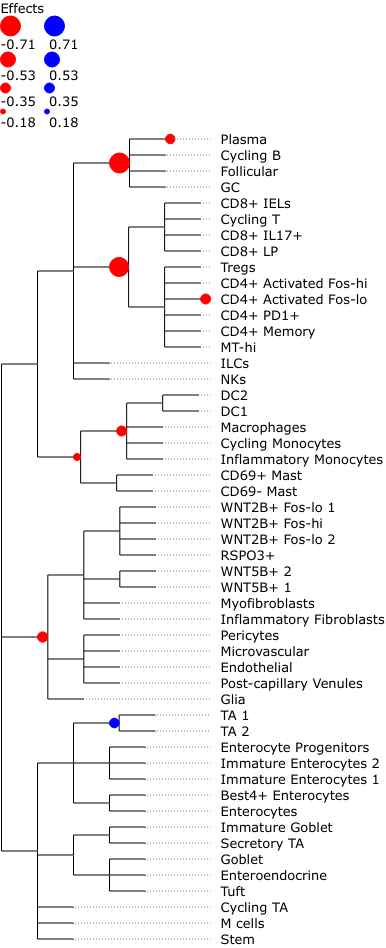

In [12]:
tasccoda_model.plot_draw_effects(
    smillie_data,
    modality_key="coda_LP",
    tree=smillie_data["coda_LP"].uns["tree"],
    covariate="Health[T.Non-inflamed]",
)

To better see the size of aggregated effects on the individual cell types, we can plot them at the side of the tree plot:

Wrote file: /home/lukas/code/pertpy-tutorials/tree_effect.png


/home/lukas/code/pertpy/pertpy/tools/_coda/_base_coda.py:2072: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=leaf_effs, x="Effect", y="Cell Type", palette=palette, ax=ax[1])


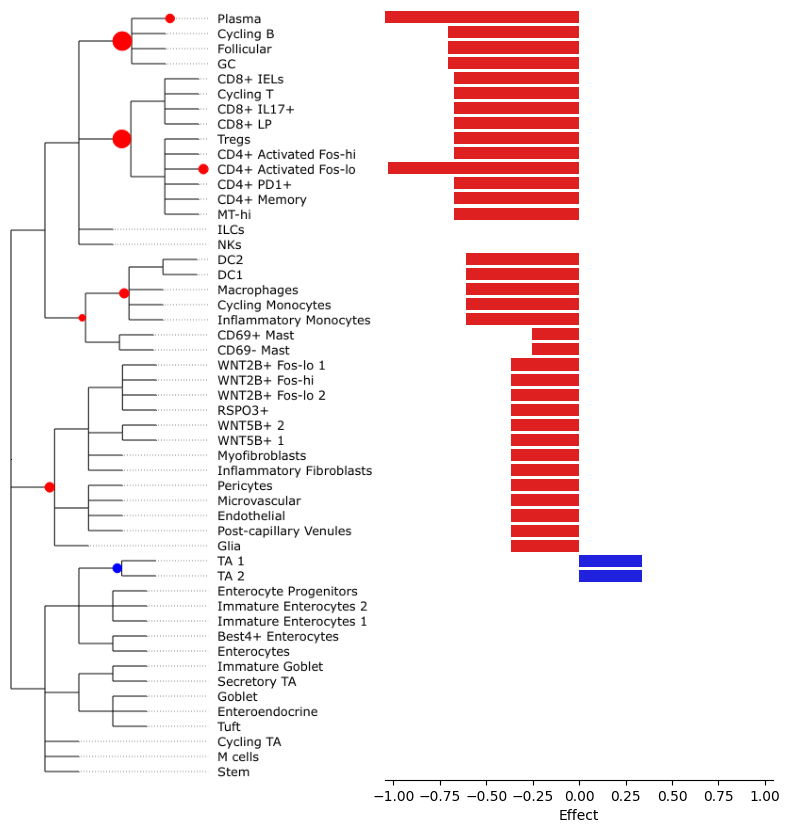

In [13]:
tasccoda_model.plot_draw_effects(
    smillie_data,
    modality_key="coda_LP",
    tree=smillie_data["coda_LP"].uns["tree"],
    covariate="Health[T.Non-inflamed]",
    show_legend=False,
    show_leaf_effects=True,
)